In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
from loguru import logger
from matplotlib import pyplot as plt
from scipy import stats
from scipy.signal import savgol_filter
import string
import math

## Overview

This notebooks demonstrates how to reproduce plots from [Snyder et. al. 2016](#CELL2016) using data generated using cfDNA UniFlow. For this we process data as described in the [Shendurelab cfDNA repository](https://github.com/shendurelab/cfDNA/tree/master) and compare it to the reprocessed data from cfDNA Uniflow, using tools and methods of the workflow. 

We reproduce the following plots:

1) Signals around the TFBS CTCF, MAFK, ETS
2) Signals around genic features (TSS, TES, etc.)
3) Signals around TSS stratified by NB-4 expression
 
<a id="CELL2016">[1]</a>
Snyder MW, Kircher M, Hill AJ, Daza RM, Shendure J. Cell-free DNA Comprises an In Vivo Nucleosome Footprint that Informs Its Tissues-Of-Origin. Cell. 2016; doi: 10.1016/j.cell.2015.11.050.

## Define Utility Functions

In [30]:
def round_floor(number,ndigits=2):
    """Rounds decimal values down."""
    factor=(10**ndigits)
    return math.floor(number*factor)/factor

In [31]:
def round_ceil(number,ndigits=2):
    """Rounds decimal values up."""
    factor=(10**ndigits)
    return math.ceil(number*factor)/factor

In [32]:
def load_table(path: str):
    """Loads table and sets index according to expected columns "ID" and optional column "coordinate"

    Args:
        path (str): path to the input file in .csv/.tsv format. Supports zipped files.

    Returns:
        pandas.DataFrame: DataFrame containing loaded data.
    """
    ## determine dtypes
    if any([x in path for x in [".tsv", ".tsv.gz"]]):
        dtype_df = pd.read_csv(path, sep="\t", header=None, nrows=1000)
    else:
        dtype_df = pd.read_csv(path, header=None, nrows=1000)

    non_numeric = dtype_df.select_dtypes(exclude=["float", "int"]).columns
    numeric = dtype_df.select_dtypes(include=["float", "int"]).columns
    dtype_dict = {key: str for key in non_numeric.values}
    dtype_dict.update({col: np.float32 for col in numeric if col not in non_numeric})
    del dtype_df
    ## load actual data
    if any([x in path for x in [".tsv", ".tsv.gz"]]):
        df = pd.read_csv(path, sep="\t", header=None, dtype=dtype_dict)
    else:
        df = pd.read_csv(path, header=None, dtype=dtype_dict)
    if pd.api.types.is_string_dtype(df[0]):
        if pd.api.types.is_string_dtype(df[1]):
            df = df.set_index([0, 1])
            df.index.names = ["ID", "coordinate"]
        else:
            df = df.set_index(0)
            df.index.name = "ID"
    return df

In [33]:
def calculate_flanking_regions(val: int):
    """Calculates flanking regions for point of interest.
    Args:
        val (int): should be length of value vector
    Raises:
        TypeError: Only integers are allowed
    Returns:
        [iterator]: range of values around center point (e.g. range(-1000,1000))
    """

    if not isinstance(val, int):
        raise TypeError("Only integers are allowed")

    if val % 2 == 0:
        flank = int(val / 2)
        region = range(-flank, flank)
    elif val % 2 == 1:
        flank_l = int(val / 2 - 0.5)
        flank_r = int(val / 2 + 0.5)
        region = range(-flank_l, flank_r)
    return region


In [34]:
def process_sample(
    sample: pd.DataFrame,
    overlay_mode: str = "mean",
    smoothing: bool = False,
    smooth_window: int = 21,
    smooth_polyorder: int = 2,
    scaling: bool = False,
    rolling: bool = False,
    rolling_window: int = 1000,
    edge_norm: bool = False,
    window: int = 1000,
    flank: int = 500,
) -> pd.DataFrame:
    """Process sample for plotting. This includes smoothing, normalization and the removal of edge regions to mitigate edge effects.

    Args:
        sample (pd.DataFrame): Sample signal extracted from cfDNA.
        overlay_mode (str, optional): Mode for aggregating signal over multiple regions. Can be mean, median or confidence interval. Defaults to "mean".
        smoothing (bool, optional): Switch on whether the signal should be smoothed. Defaults to False.
        smooth_window (int, optional): Smoothing window for Savitzky-Golay filter. Defaults to 21.
        smooth_polyorder (int, optional): Order of polynomial used in Savitzky-Golay filter. Defaults to 2.
        scaling (bool, optional): Switch on whether the signal should be standardized. Defaults to False.
        rolling (bool, optional): Switch on whether the signal should be demeaned by substracting the rolling median. Defaults to False.
        rolling_window (int, optional): Window size being used in rolling_window demeaning.
        edge_norm (bool, optional): Switch on whether the signal should be demeaned by substracting the average signal in the flanking regions. Defaults to False.
        window (int, optional): Size of window centered on region of interest. Defaults to 1000.
        flank (int, optional): Size of flanking regions for edge_norm. Defaults to 500.

    Raises:
        ValueError: Invalid overlay_mode keyword.

    Returns:
        pd.DataFrame: Processed sample.
    """

    if edge_norm:
        helper = abs(pd.concat([sample.iloc[:,:flank],sample.iloc[:,-flank:]], axis=1).median(axis=1))
        if (helper == 0).any():
            zero_mask = helper == 0
            logger.info(
                f"Regions with zero mean in Normalization slices of size {flank} encountered. Removing respective regions."
            )
            for zero_region in zero_mask[zero_mask].index:
                logger.info(f"Removing region: {zero_region}")
            helper.drop(helper[zero_mask].index, inplace=True)
            sample.drop(sample[zero_mask].index, inplace=True)
        sample = sample.div(helper, axis=0)

    if smoothing:
        sample = sample.apply(
            lambda x: savgol_filter(
                x, window_length=smooth_window, polyorder=smooth_polyorder
            ),
            axis=1,
            result_type="expand",
        )

    if overlay_mode.lower() == "mean":
        sample = pd.DataFrame(sample.mean(numeric_only=True))
    elif overlay_mode.lower() == "median":
        sample = pd.DataFrame(sample.median(numeric_only=True))
    else:
        raise ValueError(f"{overlay_mode} is not a valid keyword.")

    if rolling:
        trend = sample.rolling(rolling_window, center=True, min_periods=1).median()
        sample = sample.sub(trend)

    sample["position"] = calculate_flanking_regions(len(sample))
    sample = sample.set_index("position")

    return sample

## Set arguments

In [35]:
## Arguments for cfDNA Uniflow plotting

overlay_mode = "mean"
smoothing = True 
smooth_window = 21
smooth_polyorder = 2 
rolling = True 
rolling_window = 200
flank_norm = True
flank = 500
signal = "WPS"
display_window = [-2000,2000]
aggregate_controls = True

In [36]:
# cfDNA input files
##TFBS
TFBS_uniflow_dict = {
    "CTCF UniFlow" : f"../../results/Cell_2016/signals/signal-corrected/CTCF_Core-2.CH01-corrected_{signal}.hg38.csv.gz",
    "MAFK UniFlow" : f"../../results/Cell_2016/signals/signal-corrected/MAFK.CH01-corrected_{signal}.hg38.csv.gz",
    "ETS UniFlow" : f"../../results/Cell_2016/signals/signal-corrected/ETS.CH01-corrected_{signal}.hg38.csv.gz",
}
## Genic features
geneic_features_uniflow_dict = {
    "TSS UniFlow" : f"../../results/Cell_2016/signals/signal-corrected/TSS.CH01-corrected_{signal}.hg38.csv.gz",
    "TES UniFlow" : f"../../results/Cell_2016/signals/signal-corrected/TSE.CH01-corrected_{signal}.hg38.csv.gz",
    "Splice-donor UniFlow" : f"../../results/Cell_2016/signals/signal-corrected/exonSpliceDonor.CH01-corrected_{signal}.hg38.csv.gz",
    "Splice-acceptor UniFlow" : f"../../results/Cell_2016/signals/signal-corrected/exonSpliceAcceptor.CH01-corrected_{signal}.hg38.csv.gz",
    "Start-codon UniFlow" : f"../../results/Cell_2016/signals/signal-corrected/StartCodon.CH01-corrected_{signal}.hg38.csv.gz",
    "Stop-codon UniFlow" : f"../../results/Cell_2016/signals/signal-corrected/StopCodon.CH01-corrected_{signal}.hg38.csv.gz",
}
## TSS by expression
tss_expression_uniflow_dict = {
"low" : f"../../results/Cell_2016/signals/signal-corrected/bin1_TSS.CH01-corrected_{signal}.hg38.csv.gz",
"20-40%" : f"../../results/Cell_2016/signals/signal-corrected/bin2_TSS.CH01-corrected_{signal}.hg38.csv.gz",
"medium" : f"../../results/Cell_2016/signals/signal-corrected/bin3_TSS.CH01-corrected_{signal}.hg38.csv.gz",
"60-80%" : f"../../results/Cell_2016/signals/signal-corrected/bin4_TSS.CH01-corrected_{signal}.hg38.csv.gz",
"high" : f"../../results/Cell_2016/signals/signal-corrected/bin5_TSS.CH01-corrected_{signal}.hg38.csv.gz",
}

In [37]:
#CELL2016 input files
##TFBS
### Data
TFBS_CELL2016_dict = {
    "CTCF CELL2016" : "CELL2016_data/Maurano_et_al_plus_ChIP/CH01_CTCF_Core-2.tsv",
    "MAFK CELL2016" : "CELL2016_data/Maurano_et_al_plus_ChIP/CH01_MAFK.tsv",
    "ETS CELL2016" : "CELL2016_data/Maurano_et_al_plus_ChIP/CH01_ETS.tsv",
}
### Simulation
TFBS_CELL2016Sim_dict = {
    "CTCF CELL2016" : "CELL2016_data/Maurano_et_al_plus_ChIP/CH01_2mer_sim_CTCF_Core-2.tsv",
    "MAFK CELL2016" : "CELL2016_data/Maurano_et_al_plus_ChIP/CH01_2mer_sim_MAFK.tsv",
    "ETS CELL2016" : "CELL2016_data/Maurano_et_al_plus_ChIP/CH01_2mer_sim_ETS.tsv",
}
## Genic features
### Data
geneic_features_CELL2016_dict = {
    "TSS CELL2016" : "CELL2016_data/genicFeatures/CH01_TSS.tsv",
    "TES CELL2016" : "CELL2016_data/genicFeatures/CH01_TSE.tsv",
    "Splice-donor CELL2016" : "CELL2016_data/genicFeatures/CH01_exonSpliceDonor.tsv",
    "Splice-acceptor CELL2016" : "CELL2016_data/genicFeatures/CH01_exonSpliceAcceptor.tsv",
    "Start-codon CELL2016" : "CELL2016_data/genicFeatures/CH01_StartCodon.tsv",
    "Stop-codon CELL2016" : "CELL2016_data/genicFeatures/CH01_StopCodon.tsv",
}
### Simulation
geneic_features_CELL2016Sim_dict = {
    "TSS CELL2016" : "CELL2016_data/genicFeatures/CH01_2mer_sim_TSS.tsv",
    "TES CELL2016" : "CELL2016_data/genicFeatures/CH01_2mer_sim_TSE.tsv",
    "Splice-donor CELL2016" : "CELL2016_data/genicFeatures/CH01_2mer_sim_exonSpliceDonor.tsv",
    "Splice-acceptor CELL2016" : "CELL2016_data/genicFeatures/CH01_2mer_sim_exonSpliceAcceptor.tsv",
    "Start-codon CELL2016" : "CELL2016_data/genicFeatures/CH01_2mer_sim_StartCodon.tsv",
    "Stop-codon CELL2016" : "CELL2016_data/genicFeatures/CH01_2mer_sim_StopCodon.tsv",
}
## TSS by expression
### Data
tss_expression_CELL2016_dict = {
"low" : "CELL2016_data/genicFeatures_by_expression/CH01_TSS_bin1.tsv",
"20-40%" : "CELL2016_data/genicFeatures_by_expression/CH01_TSS_bin2.tsv",
"medium" : "CELL2016_data/genicFeatures_by_expression/CH01_TSS_bin3.tsv",
"60-80%" : "CELL2016_data/genicFeatures_by_expression/CH01_TSS_bin4.tsv",
"high" : "CELL2016_data/genicFeatures_by_expression/CH01_TSS_bin5.tsv",
}
### Simulation
tss_expression_CELL2016Sim_dict = {
"low" : "CELL2016_data/genicFeatures_by_expression/CH01_2mer_sim_TSS_bin1.tsv",
"20-40%" : "CELL2016_data/genicFeatures_by_expression/CH01_2mer_sim_TSS_bin2.tsv",
"medium" : "CELL2016_data/genicFeatures_by_expression/CH01_2mer_sim_TSS_bin3.tsv",
"60-80%" : "CELL2016_data/genicFeatures_by_expression/CH01_2mer_sim_TSS_bin4.tsv",
"high" : "CELL2016_data/genicFeatures_by_expression/CH01_2mer_sim_TSS_bin5.tsv",
}

## Prepare data

### cfDNA Uniflow data

In [38]:
TFBS_uniflow_df = pd.DataFrame()
for name,path in TFBS_uniflow_dict.items():
    print(name,path)
    tmpdf = load_table(path)
    tmpdf = process_sample(
        sample=tmpdf,
        overlay_mode=overlay_mode,
        smoothing=smoothing,
        smooth_window=smooth_window,
        smooth_polyorder=smooth_polyorder,
        rolling=rolling,
        rolling_window=rolling_window,
        edge_norm=flank_norm,
        flank=flank,
    )
    TFBS_uniflow_df[name] = tmpdf
    del tmpdf

CTCF UniFlow ../../results/Cell_2016/signals/signal-corrected/CTCF_Core-2.CH01-corrected_WPS.hg38.csv.gz


2024-08-05 20:39:47.508 | INFO     | __main__:process_sample:40 - Regions with zero mean in Normalization slices of size 500 encountered. Removing respective regions.
2024-08-05 20:39:47.512 | INFO     | __main__:process_sample:44 - Removing region: ('CTCF_Core/2', 'chr1:235250-240250')
2024-08-05 20:39:47.513 | INFO     | __main__:process_sample:44 - Removing region: ('CTCF_Core/2', 'chr1:228578825-228583825')
2024-08-05 20:39:47.513 | INFO     | __main__:process_sample:44 - Removing region: ('CTCF_Core/2', 'chr13:111717798-111722798')
2024-08-05 20:39:47.514 | INFO     | __main__:process_sample:44 - Removing region: ('CTCF_Core/2', 'chr13:111804009-111809009')
2024-08-05 20:39:47.515 | INFO     | __main__:process_sample:44 - Removing region: ('CTCF_Core/2', 'chr13:113681491-113686491')
2024-08-05 20:39:47.515 | INFO     | __main__:process_sample:44 - Removing region: ('CTCF_Core/2', 'chr13:113681531-113686531')
2024-08-05 20:39:47.516 | INFO     | __main__:process_sample:44 - Removin

MAFK UniFlow ../../results/Cell_2016/signals/signal-corrected/MAFK.CH01-corrected_WPS.hg38.csv.gz


2024-08-05 20:41:01.915 | INFO     | __main__:process_sample:40 - Regions with zero mean in Normalization slices of size 500 encountered. Removing respective regions.
2024-08-05 20:41:01.918 | INFO     | __main__:process_sample:44 - Removing region: ('MAFK', 'chr3:162808460-162813460')


ETS UniFlow ../../results/Cell_2016/signals/signal-corrected/ETS.CH01-corrected_WPS.hg38.csv.gz


2024-08-05 20:48:10.676 | INFO     | __main__:process_sample:40 - Regions with zero mean in Normalization slices of size 500 encountered. Removing respective regions.
2024-08-05 20:48:10.680 | INFO     | __main__:process_sample:44 - Removing region: ('ETS', 'chr20:1586123-1591123')
2024-08-05 20:48:10.680 | INFO     | __main__:process_sample:44 - Removing region: ('ETS', 'chr20:1586246-1591246')
2024-08-05 20:48:10.681 | INFO     | __main__:process_sample:44 - Removing region: ('ETS', 'chr20:1586368-1591368')
2024-08-05 20:48:10.681 | INFO     | __main__:process_sample:44 - Removing region: ('ETS', 'chr20:1593037-1598037')
2024-08-05 20:48:10.682 | INFO     | __main__:process_sample:44 - Removing region: ('ETS', 'chr3:162879242-162884242')
2024-08-05 20:48:10.684 | INFO     | __main__:process_sample:44 - Removing region: ('ETS', 'chr3:162879363-162884363')


In [39]:
geneic_features_uniflow_df = pd.DataFrame()
for name,path in geneic_features_uniflow_dict.items():
    print(name,path)
    tmpdf = load_table(path)
    tmpdf = process_sample(
        sample=tmpdf,
        overlay_mode=overlay_mode,
        smoothing=smoothing,
        smooth_window=smooth_window,
        smooth_polyorder=smooth_polyorder,
        rolling=rolling,
        rolling_window=rolling_window,
        edge_norm=flank_norm,
        flank=flank,
    )
    geneic_features_uniflow_df[name] = tmpdf
    del tmpdf

TSS UniFlow ../../results/Cell_2016/signals/signal-corrected/TSS.CH01-corrected_WPS.hg38.csv.gz


2024-08-05 20:52:04.467 | INFO     | __main__:process_sample:40 - Regions with zero mean in Normalization slices of size 500 encountered. Removing respective regions.
2024-08-05 20:52:04.470 | INFO     | __main__:process_sample:44 - Removing region: ('TSS', 'chr20:1586169-1591169')
2024-08-05 20:52:04.471 | INFO     | __main__:process_sample:44 - Removing region: ('TSS', 'chr19:54721979-54726979')


TES UniFlow ../../results/Cell_2016/signals/signal-corrected/TSE.CH01-corrected_WPS.hg38.csv.gz


2024-08-05 20:52:55.520 | INFO     | __main__:process_sample:40 - Regions with zero mean in Normalization slices of size 500 encountered. Removing respective regions.
2024-08-05 20:52:55.522 | INFO     | __main__:process_sample:44 - Removing region: ('TSE', 'chr1:1350191-1355191')


Splice-donor UniFlow ../../results/Cell_2016/signals/signal-corrected/exonSpliceDonor.CH01-corrected_WPS.hg38.csv.gz


2024-08-05 20:59:26.482 | INFO     | __main__:process_sample:40 - Regions with zero mean in Normalization slices of size 500 encountered. Removing respective regions.
2024-08-05 20:59:26.486 | INFO     | __main__:process_sample:44 - Removing region: ('exonSpliceDonor', 'chr1:1350191-1355191')
2024-08-05 20:59:26.486 | INFO     | __main__:process_sample:44 - Removing region: ('exonSpliceDonor', 'chrX:339383-344383')
2024-08-05 20:59:26.487 | INFO     | __main__:process_sample:44 - Removing region: ('exonSpliceDonor', 'chr13:113720657-113725657')
2024-08-05 20:59:26.488 | INFO     | __main__:process_sample:44 - Removing region: ('exonSpliceDonor', 'chr20:1586060-1591060')
2024-08-05 20:59:26.488 | INFO     | __main__:process_sample:44 - Removing region: ('exonSpliceDonor', 'chr19:54722030-54727030')
2024-08-05 20:59:26.489 | INFO     | __main__:process_sample:44 - Removing region: ('exonSpliceDonor', 'chr19:54722782-54727782')
2024-08-05 20:59:26.490 | INFO     | __main__:process_sample:

Splice-acceptor UniFlow ../../results/Cell_2016/signals/signal-corrected/exonSpliceAcceptor.CH01-corrected_WPS.hg38.csv.gz


2024-08-05 21:08:56.009 | INFO     | __main__:process_sample:40 - Regions with zero mean in Normalization slices of size 500 encountered. Removing respective regions.
2024-08-05 21:08:56.013 | INFO     | __main__:process_sample:44 - Removing region: ('exonSpliceAcceptor', 'chrX:339431-344431')
2024-08-05 21:08:56.014 | INFO     | __main__:process_sample:44 - Removing region: ('exonSpliceAcceptor', 'chr13:113720574-113725574')
2024-08-05 21:08:56.014 | INFO     | __main__:process_sample:44 - Removing region: ('exonSpliceAcceptor', 'chr20:1586169-1591169')
2024-08-05 21:08:56.015 | INFO     | __main__:process_sample:44 - Removing region: ('exonSpliceAcceptor', 'chr19:54721979-54726979')
2024-08-05 21:08:56.016 | INFO     | __main__:process_sample:44 - Removing region: ('exonSpliceAcceptor', 'chr19:54722747-54727747')
2024-08-05 21:08:56.016 | INFO     | __main__:process_sample:44 - Removing region: ('exonSpliceAcceptor', 'chr19:54723553-54728553')
2024-08-05 21:08:56.018 | INFO     | __m

Start-codon UniFlow ../../results/Cell_2016/signals/signal-corrected/StartCodon.CH01-corrected_WPS.hg38.csv.gz


2024-08-05 21:12:44.852 | INFO     | __main__:process_sample:40 - Regions with zero mean in Normalization slices of size 500 encountered. Removing respective regions.
2024-08-05 21:12:44.855 | INFO     | __main__:process_sample:44 - Removing region: ('StartCodon', 'chr19:54721997-54726997')


Stop-codon UniFlow ../../results/Cell_2016/signals/signal-corrected/StopCodon.CH01-corrected_WPS.hg38.csv.gz


In [40]:
tss_expression_uniflow_df = pd.DataFrame()
for name,path in tss_expression_uniflow_dict.items():
    print(name,path)
    tmpdf = load_table(path)
    tmpdf = process_sample(
        sample=tmpdf,
        overlay_mode=overlay_mode,
        smoothing=smoothing,
        smooth_window=smooth_window,
        smooth_polyorder=smooth_polyorder,
        rolling=rolling,
        rolling_window=rolling_window,
        edge_norm=flank_norm,
        flank=flank,
    )
    tss_expression_uniflow_df[name] = tmpdf
    del tmpdf

low ../../results/Cell_2016/signals/signal-corrected/bin1_TSS.CH01-corrected_WPS.hg38.csv.gz
20-40% ../../results/Cell_2016/signals/signal-corrected/bin2_TSS.CH01-corrected_WPS.hg38.csv.gz
medium ../../results/Cell_2016/signals/signal-corrected/bin3_TSS.CH01-corrected_WPS.hg38.csv.gz


2024-08-05 21:14:20.897 | INFO     | __main__:process_sample:40 - Regions with zero mean in Normalization slices of size 500 encountered. Removing respective regions.
2024-08-05 21:14:20.899 | INFO     | __main__:process_sample:44 - Removing region: ('bin3_TSS', 'chr20:1586169-1591169')


60-80% ../../results/Cell_2016/signals/signal-corrected/bin4_TSS.CH01-corrected_WPS.hg38.csv.gz
high ../../results/Cell_2016/signals/signal-corrected/bin5_TSS.CH01-corrected_WPS.hg38.csv.gz


### CELL2016 data

In [41]:
def adjust_WPS_cell(df, flank=500):
    helper = abs(pd.concat([df.iloc[:flank,:],df.iloc[-flank:,:]]).mean())
    norm_df = df.div(helper)
    processed_data = norm_df.sub(norm_df.rolling(200, center=True, min_periods=1, axis=0).mean())
    return processed_data

In [42]:
TFBS_CELL2016_df = pd.DataFrame()
for name,path in TFBS_CELL2016_dict.items():
    simpath = TFBS_CELL2016Sim_dict[name]
    print(f"Name: {name}\n Data path: {path}\n SimData path: {simpath}")
    datadf = pd.read_csv(path,sep="\t", index_col="#Pos").sum(axis=1)
    simdf = pd.read_csv(simpath,sep="\t", index_col="#Pos").sum(axis=1)
    datadf = adjust_WPS_cell(pd.DataFrame(datadf))
    simdf = adjust_WPS_cell(pd.DataFrame(simdf))
    TFBS_CELL2016_df[name+"_data"] = datadf
    TFBS_CELL2016_df[name+"_simulation"] = simdf
    TFBS_CELL2016_df[name+"_adjusted"] = datadf.sub(simdf)
    del datadf
    del simdf

Name: CTCF CELL2016
 Data path: CELL2016_data/Maurano_et_al_plus_ChIP/CH01_CTCF_Core-2.tsv
 SimData path: CELL2016_data/Maurano_et_al_plus_ChIP/CH01_2mer_sim_CTCF_Core-2.tsv
Name: MAFK CELL2016
 Data path: CELL2016_data/Maurano_et_al_plus_ChIP/CH01_MAFK.tsv
 SimData path: CELL2016_data/Maurano_et_al_plus_ChIP/CH01_2mer_sim_MAFK.tsv
Name: ETS CELL2016
 Data path: CELL2016_data/Maurano_et_al_plus_ChIP/CH01_ETS.tsv
 SimData path: CELL2016_data/Maurano_et_al_plus_ChIP/CH01_2mer_sim_ETS.tsv


In [43]:
geneic_features_CELL2016_df = pd.DataFrame()
for name,path in geneic_features_CELL2016_dict.items():
    simpath = geneic_features_CELL2016Sim_dict[name]
    print(f"Name: {name}\n Data path: {path}\n SimData path: {simpath}")
    datadf = pd.read_csv(path,sep="\t", index_col="#Pos").sum(axis=1)
    simdf = pd.read_csv(simpath,sep="\t", index_col="#Pos").sum(axis=1)
    datadf = adjust_WPS_cell(pd.DataFrame(datadf))
    simdf = adjust_WPS_cell(pd.DataFrame(simdf))
    geneic_features_CELL2016_df[name+"_data"] = datadf
    geneic_features_CELL2016_df[name+"_simulation"] = simdf
    geneic_features_CELL2016_df[name+"_adjusted"] = datadf.sub(simdf)
    del datadf
    del simdf

Name: TSS CELL2016
 Data path: CELL2016_data/genicFeatures/CH01_TSS.tsv
 SimData path: CELL2016_data/genicFeatures/CH01_2mer_sim_TSS.tsv
Name: TES CELL2016
 Data path: CELL2016_data/genicFeatures/CH01_TSE.tsv
 SimData path: CELL2016_data/genicFeatures/CH01_2mer_sim_TSE.tsv
Name: Splice-donor CELL2016
 Data path: CELL2016_data/genicFeatures/CH01_exonSpliceDonor.tsv
 SimData path: CELL2016_data/genicFeatures/CH01_2mer_sim_exonSpliceDonor.tsv
Name: Splice-acceptor CELL2016
 Data path: CELL2016_data/genicFeatures/CH01_exonSpliceAcceptor.tsv
 SimData path: CELL2016_data/genicFeatures/CH01_2mer_sim_exonSpliceAcceptor.tsv
Name: Start-codon CELL2016
 Data path: CELL2016_data/genicFeatures/CH01_StartCodon.tsv
 SimData path: CELL2016_data/genicFeatures/CH01_2mer_sim_StartCodon.tsv
Name: Stop-codon CELL2016
 Data path: CELL2016_data/genicFeatures/CH01_StopCodon.tsv
 SimData path: CELL2016_data/genicFeatures/CH01_2mer_sim_StopCodon.tsv


In [44]:
tss_expression_CELL2016_df = pd.DataFrame()
for name,path in tss_expression_CELL2016_dict.items():
    simpath = tss_expression_CELL2016Sim_dict[name]
    print(f"Name: {name}\n Data path: {path}\n SimData path: {simpath}")
    datadf = pd.read_csv(path,sep="\t", index_col="#Pos").sum(axis=1)
    simdf = pd.read_csv(simpath,sep="\t", index_col="#Pos").sum(axis=1)
    datadf = adjust_WPS_cell(pd.DataFrame(datadf))
    simdf = adjust_WPS_cell(pd.DataFrame(simdf))
    tss_expression_CELL2016_df[name+"_data"] = datadf
    tss_expression_CELL2016_df[name+"_simulation"] = simdf
    tss_expression_CELL2016_df[name+"_adjusted"] = datadf.sub(simdf)
    del datadf
    del simdf

Name: low
 Data path: CELL2016_data/genicFeatures_by_expression/CH01_TSS_bin1.tsv
 SimData path: CELL2016_data/genicFeatures_by_expression/CH01_2mer_sim_TSS_bin1.tsv
Name: 20-40%
 Data path: CELL2016_data/genicFeatures_by_expression/CH01_TSS_bin2.tsv
 SimData path: CELL2016_data/genicFeatures_by_expression/CH01_2mer_sim_TSS_bin2.tsv
Name: medium
 Data path: CELL2016_data/genicFeatures_by_expression/CH01_TSS_bin3.tsv
 SimData path: CELL2016_data/genicFeatures_by_expression/CH01_2mer_sim_TSS_bin3.tsv
Name: 60-80%
 Data path: CELL2016_data/genicFeatures_by_expression/CH01_TSS_bin4.tsv
 SimData path: CELL2016_data/genicFeatures_by_expression/CH01_2mer_sim_TSS_bin4.tsv
Name: high
 Data path: CELL2016_data/genicFeatures_by_expression/CH01_TSS_bin5.tsv
 SimData path: CELL2016_data/genicFeatures_by_expression/CH01_2mer_sim_TSS_bin5.tsv


## Create Plots

In the following section, 3 plots are generated:

1) Plots showing the signals extracted for CTCF, MAFK and ETS. The plots are inspired by Figure 4 A,E,F of [Snyder et. al. 2016](#CELL2016) 
2) Plots showing signals around genic features inspired by Figure 3 A-D of [Snyder et. al. 2016](#CELL2016)
3) Plots showing signals around Transcription Start Sites (TSS) stratified by expression bins, inspired by Figure 5 B of [Snyder et. al. 2016](#CELL2016) 

<a id="CELL2016">[1]</a>
Snyder MW, Kircher M, Hill AJ, Daza RM, Shendure J. Cell-free DNA Comprises an In Vivo Nucleosome Footprint that Informs Its Tissues-Of-Origin. Cell. 2016; doi: 10.1016/j.cell.2015.11.050.

### TFBS plots

In [45]:
TFBS_CELL2016_plot_df = TFBS_CELL2016_df.loc[:, TFBS_CELL2016_df.columns.str.contains("adjusted")]
TFBS_CELL2016_plot_df.index = TFBS_CELL2016_plot_df.index-len(TFBS_CELL2016_plot_df.index)/2
TFBS_CELL2016_plot_df.columns = TFBS_CELL2016_plot_df.columns.str.removesuffix("_adjusted")

In [46]:
for i in zip(TFBS_CELL2016_plot_df, TFBS_uniflow_df):
    print(i)

('CTCF CELL2016', 'CTCF UniFlow')
('MAFK CELL2016', 'MAFK UniFlow')
('ETS CELL2016', 'ETS UniFlow')


0 ('CTCF CELL2016', 'CTCF UniFlow')
1 ('MAFK CELL2016', 'MAFK UniFlow')
2 ('ETS CELL2016', 'ETS UniFlow')


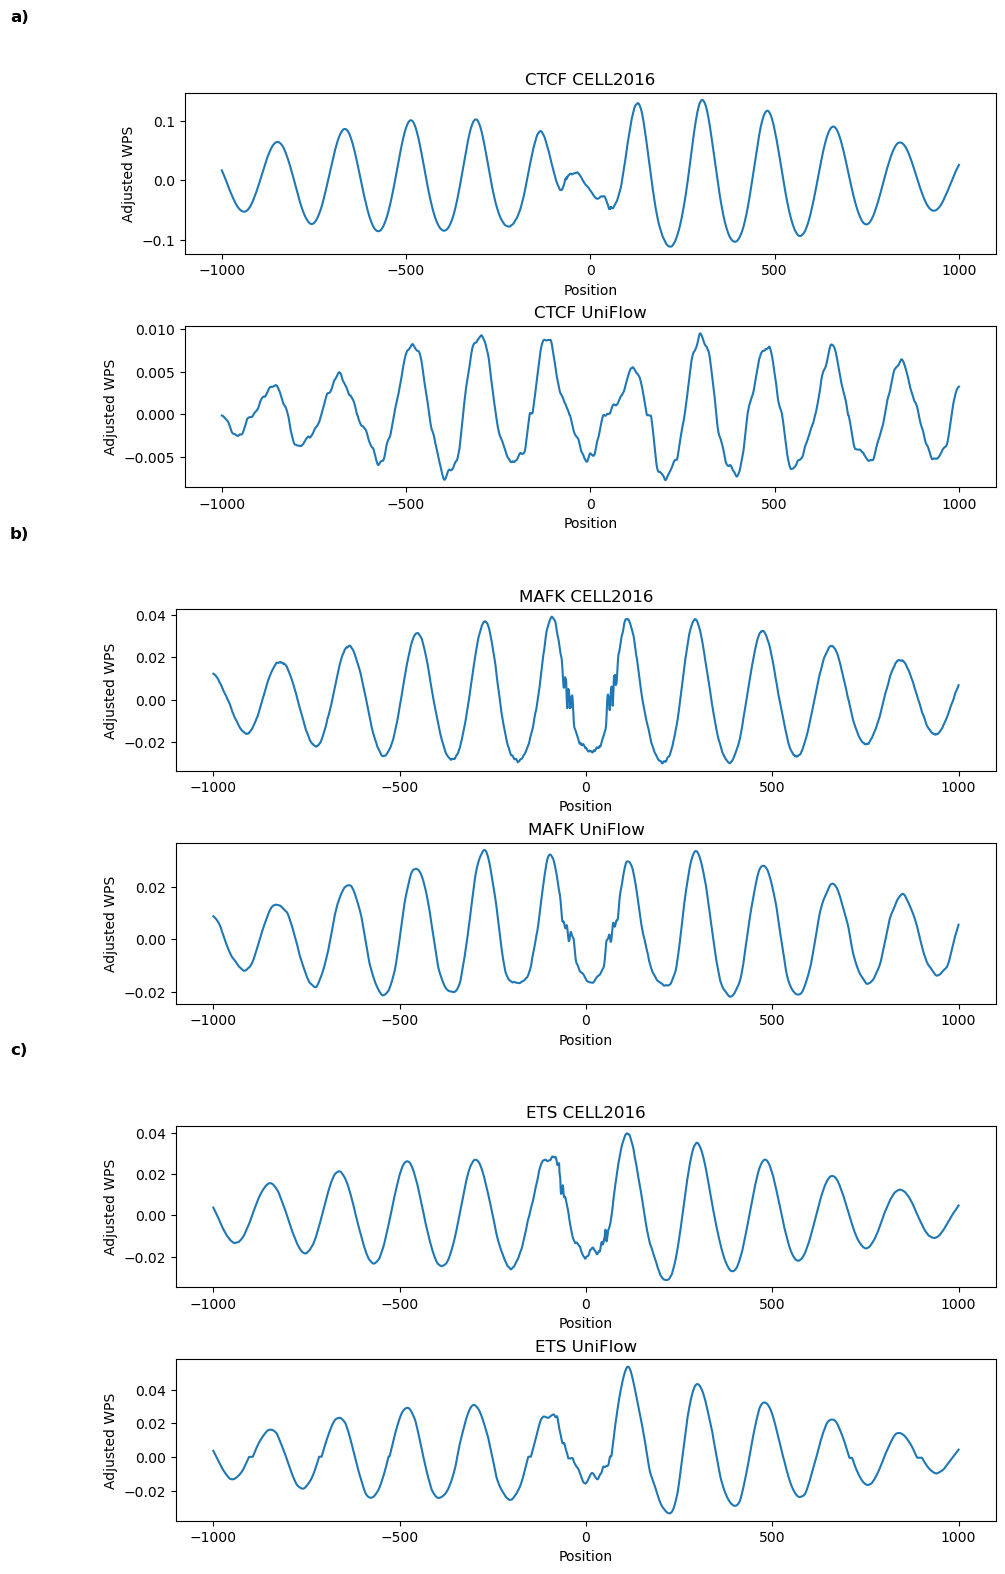

In [47]:
TFBS_fig = plt.figure(figsize=(9, (len(TFBS_CELL2016_plot_df.columns)*5)), constrained_layout=True)
subfigs = TFBS_fig.subfigures(nrows=len(TFBS_CELL2016_plot_df.columns), ncols=1, hspace=0.1)
axs = [subfig.subplots(nrows=2, ncols=1, gridspec_kw={'hspace': 0.0}) for subfig in subfigs.ravel()]

for idx,subfig in enumerate(subfigs):
       subfig.text(
           -0.1,
           1.1,
           string.ascii_lowercase[idx] + ")",
           weight="bold",
           size="large",
      )

for idx, IDs in enumerate(zip(TFBS_CELL2016_plot_df, TFBS_uniflow_df)):
    print(idx, IDs)
    CELL_Series = TFBS_CELL2016_plot_df[IDs[0]]
    UniFlow_Series= TFBS_uniflow_df[IDs[1]]
    # plot data from Cell2016
    axs[idx][0].plot(CELL_Series.loc[-1000:1000])
    axs[idx][0].set_ylabel("Adjusted WPS")
    axs[idx][0].set_xticks(list(range(-1000,1000+1,500)))
    axs[idx][0].set_xlabel("Position")
    axs[idx][0].set_title(IDs[0])
    
    axs[idx][1].plot(UniFlow_Series.loc[-1000:1000])
    axs[idx][1].set_ylabel("Adjusted WPS")
    axs[idx][1].set_xticks(list(range(-1000,1000+1,500)))
    axs[idx][1].set_xlabel("Position")
    axs[idx][1].set_title(IDs[1])

In [48]:
TFBS_fig.savefig("TFBS_CELL_vs_UniFlow.png", bbox_inches="tight", dpi=300)

### Genic features plot

In [49]:
geneic_features_CELL2016_plot_df = geneic_features_CELL2016_df.loc[:, geneic_features_CELL2016_df.columns.str.contains("adjusted")]
geneic_features_CELL2016_plot_df.index = geneic_features_CELL2016_plot_df.index-len(geneic_features_CELL2016_plot_df.index)/2
geneic_features_CELL2016_plot_df.columns = geneic_features_CELL2016_plot_df.columns.str.removesuffix("_adjusted")

In [50]:
for i in zip(geneic_features_CELL2016_plot_df, geneic_features_uniflow_df):
    print(i)

('TSS CELL2016', 'TSS UniFlow')
('TES CELL2016', 'TES UniFlow')
('Splice-donor CELL2016', 'Splice-donor UniFlow')
('Splice-acceptor CELL2016', 'Splice-acceptor UniFlow')
('Start-codon CELL2016', 'Start-codon UniFlow')
('Stop-codon CELL2016', 'Stop-codon UniFlow')


0 ('TSS CELL2016', 'TSS UniFlow')
1 ('TES CELL2016', 'TES UniFlow')
2 ('Splice-donor CELL2016', 'Splice-donor UniFlow')
3 ('Splice-acceptor CELL2016', 'Splice-acceptor UniFlow')
4 ('Start-codon CELL2016', 'Start-codon UniFlow')
5 ('Stop-codon CELL2016', 'Stop-codon UniFlow')


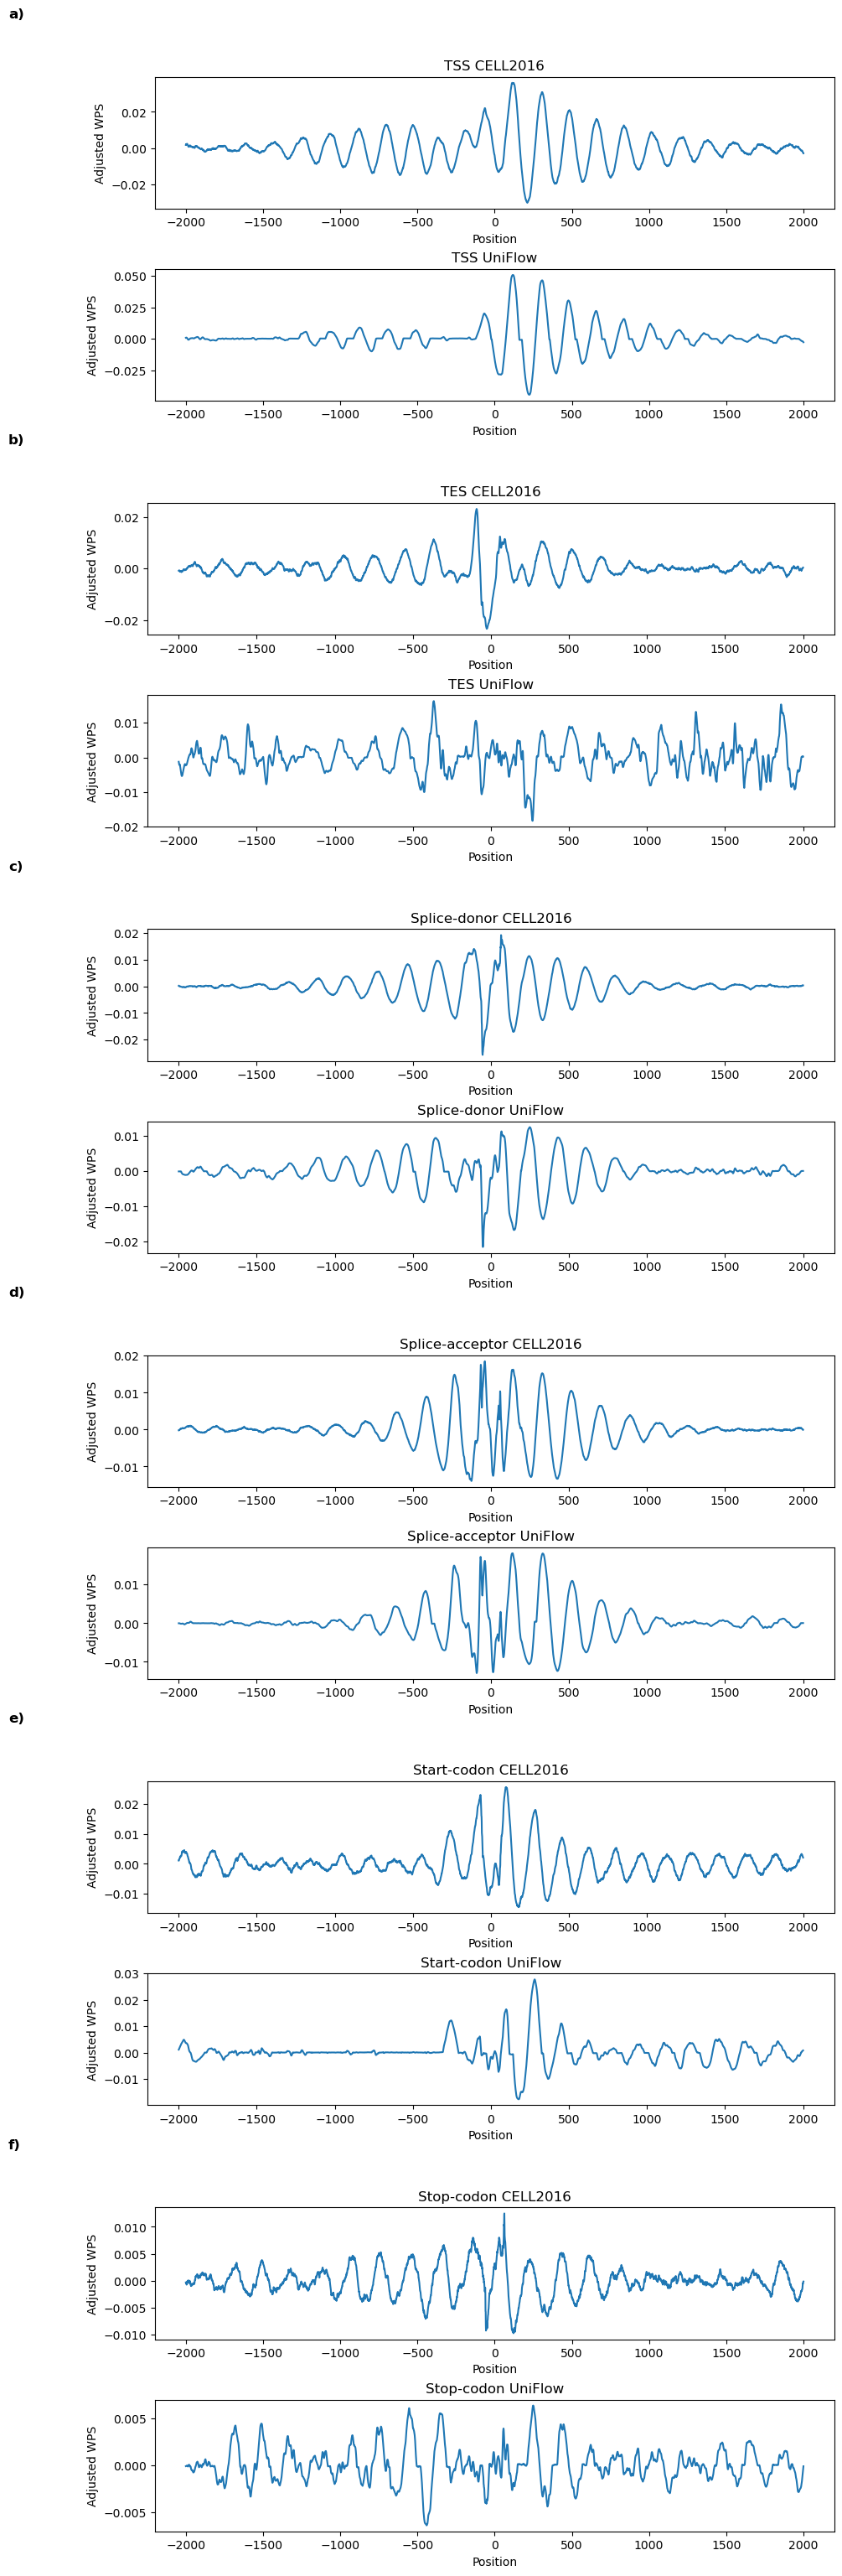

In [51]:
geneic_features_fig = plt.figure(figsize=(9, (len(geneic_features_CELL2016_plot_df.columns)*5)), constrained_layout=True)
subfigs = geneic_features_fig.subfigures(nrows=len(geneic_features_CELL2016_plot_df.columns), ncols=1, hspace=0.1)
axs = [subfig.subplots(nrows=2, ncols=1, gridspec_kw={'hspace': 0.0}) for subfig in subfigs.ravel()]

for idx,subfig in enumerate(subfigs):
       subfig.text(
          -0.1,
          1.1,
          string.ascii_lowercase[idx] + ")",
          weight="bold",
          size="large",
      )

for idx, IDs in enumerate(zip(geneic_features_CELL2016_plot_df, geneic_features_uniflow_df)):
    print(idx, IDs)
    CELL_Series = geneic_features_CELL2016_plot_df[IDs[0]]
    UniFlow_Series= geneic_features_uniflow_df[IDs[1]]
    # plot data from Cell2016
    axs[idx][0].plot(CELL_Series.loc[-2000:2000])
    axs[idx][0].set_ylabel("Adjusted WPS")
    axs[idx][0].set_xticks(list(range(-2000,2000+1,500)))
    axs[idx][0].set_xlabel("Position")
    axs[idx][0].set_title(IDs[0])
    
    axs[idx][1].plot(UniFlow_Series.loc[-2000:2000])
    axs[idx][1].set_ylabel("Adjusted WPS")
    axs[idx][1].set_xticks(list(range(-2000,2000+1,500)))
    axs[idx][1].set_xlabel("Position")
    axs[idx][1].set_title(IDs[1])

In [52]:
geneic_features_fig.savefig("geneic_features_CELL_vs_UniFlow.png", bbox_inches="tight", dpi=300)

### TSS Expression Plots

In [53]:
tss_expression_CELL2016_plot_df = tss_expression_CELL2016_df.loc[:, tss_expression_CELL2016_df.columns.str.contains("adjusted")]
tss_expression_CELL2016_plot_df.index = tss_expression_CELL2016_plot_df.index-len(tss_expression_CELL2016_plot_df.index)/2
tss_expression_CELL2016_plot_df.columns = tss_expression_CELL2016_plot_df.columns.str.removesuffix("_adjusted")

In [54]:
selColors = ["#b2182b","#ef8a62","#fddbc7","#67a9cf","#2166ac"]#.reverse()

0 ('high', 'high')
1 ('60-80%', '60-80%')
2 ('medium', 'medium')
3 ('20-40%', '20-40%')
4 ('low', 'low')


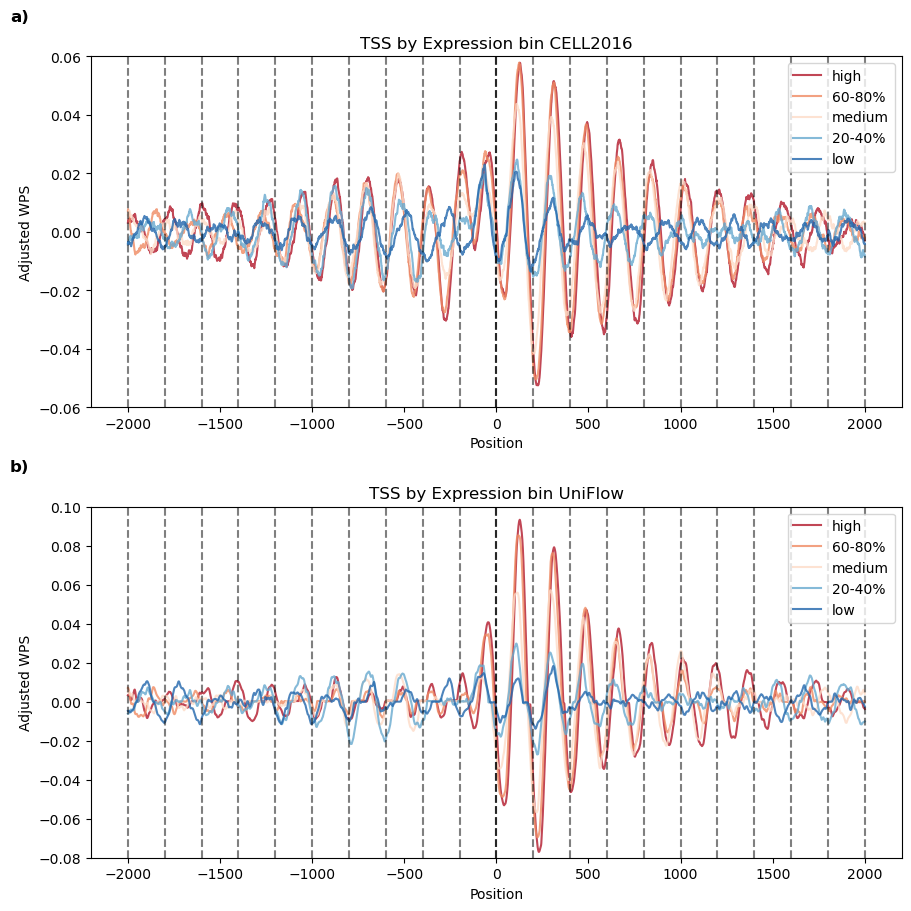

In [55]:
fig_expression,axs = plt.subplots(nrows=2,ncols=1, layout="constrained", figsize=(9,9))
axs = axs.flatten()
for idx, IDs in enumerate(zip(tss_expression_CELL2016_plot_df.iloc[:,::-1], tss_expression_uniflow_df.iloc[:,::-1])):
    print(idx, IDs)
    CELL_Series = tss_expression_CELL2016_plot_df[IDs[0]]
    UniFlow_Series=tss_expression_uniflow_df[IDs[1]]
    ## plot data from Cell2016
    axs[0].plot(CELL_Series.loc[-2000:2000], color=selColors[idx], label=IDs[0], alpha=0.8)
    axs[1].plot(UniFlow_Series.loc[-2000:2000], color=selColors[idx], label=IDs[1], alpha=0.8)
# Set plotting parameters for CELL data
axs[0].text(
            -0.1,
            1.1,
            string.ascii_lowercase[0] + ")",
            transform=axs[0].transAxes,
            weight="bold",
            size="large",
      )
axs[0].set_ylabel("Adjusted WPS")
axs[0].set_xticks(list(range(-2000,2000+1,500)))
axs[0].set_xlabel("Position")
axs[0].set_title("TSS by Expression bin CELL2016")
CELL_ymin = round_floor(tss_expression_CELL2016_plot_df.min().min())
CELL_ymax = round_ceil(tss_expression_CELL2016_plot_df.max().max())
axs[0].set_ylim(ymin=CELL_ymin, ymax=CELL_ymax)
axs[0].legend()
axs[0].vlines(list(range(-2000,2000+1,200)), ymin=CELL_ymin, ymax=CELL_ymax, color="black", linestyles="--", alpha=0.5)
axs[0].vlines(0, ymin=CELL_ymin, ymax=CELL_ymax, color="black", linestyles="--", alpha=0.7)
# Set Plotting parameters for cfDNA UniFlow data
axs[1].text(
            -0.1,
            1.1,
            string.ascii_lowercase[1] + ")",
            transform=axs[1].transAxes,
            weight="bold",
            size="large",
      )
axs[1].set_ylabel("Adjusted WPS")
axs[1].set_xticks(list(range(-2000,2000+1,500)))
axs[1].set_xlabel("Position")
axs[1].set_title("TSS by Expression bin UniFlow")
UniFlow_ymin = round_floor(tss_expression_uniflow_df.min().min())
UniFlow_ymax = round_ceil(tss_expression_uniflow_df.max().max())
axs[1].set_ylim(ymin=UniFlow_ymin, ymax=UniFlow_ymax)
axs[1].legend()
axs[1].vlines(list(range(-2000,2000+1,200)), ymin=UniFlow_ymin, ymax=UniFlow_ymax, color="black", linestyles="--", alpha=0.5)
axs[1].vlines(0, ymin=UniFlow_ymin, ymax=UniFlow_ymax, color="black", linestyles="--", alpha=0.7)


In [ ]:
fig_expression.savefig("expression_TSS_CELL_vs_UniFlow.png", bbox_inches="tight", dpi=300)